# We used the code from the the following book to be able to produce iterativly predictions for Neural Nets on our dataset
https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, TimeDistributed
from sklearn.linear_model import LinearRegression
import pandas as pd
from common import *


# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# The plotting methods are collected from 
https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [2]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    plt.ylim(0,1)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [3]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.ylim(0,1)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [4]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# Sliding window. 
The algorithm is inspired from code produced in another course IN5410 at UIO

In [5]:
def create_time_series_data(raw_train_df, nbf_features, nbf_outputs, column_key, column_suffix="", include_target_outputs=True):
    nbf_columns = nbf_features + nbf_outputs
    time_series_df, time_series = sliding_window_algorithm(raw_train_df, nbf_columns, nbf_features, nbf_outputs, column_key, column_suffix, include_target_outputs)
    return time_series, time_series_df


def sliding_window_algorithm(raw_data_df, nbf_columns, input_window, output_window, column_key, column_suffix, include_target_outputs, string_array=False):
    raw_data = raw_data_df[column_key].to_numpy()
    dim0 = raw_data.shape[0] - (nbf_columns - 1) # Number of time-slices
    dim1 = nbf_columns # Time-step length including input window and output window
    
    if string_array:
        data = np.empty((dim0,dim1), dtype=object) # Time series matrix
    else:
        data = np.zeros((dim0,dim1)) # Time series matrix

    data[0, :] = raw_data[:dim1] # First initial sample/time-slice (n equals 0)
    n = 1 # n is the count variable
    
    for j in range(dim1, raw_data.shape[0]):
        data[n, :-1] = data[n-1, 1:]
        data[n, nbf_columns-1:] = raw_data[j]
        n += 1

    if include_target_outputs:
        # Creating dataframe    
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+1)]
        if(output_window > 1):
            output_names = [f"y{i}_{column_suffix}" for i in range(1,output_window+1)]    
        else:
            output_names = [f"y_{column_suffix}"]
        
        time_series_df = pd.DataFrame(data=data, columns=feature_names+output_names)
    else:
        feature_names = [f"x{i}_{column_suffix}" for i in range(1,input_window+2)]
        time_series_df = pd.DataFrame(data=data, columns=feature_names)

    return time_series_df, data

# Loading our data

In [6]:
# Training data
dataset_df = pd.read_csv(f"{INPUT_DATA}MAIN_DATASET.csv")[["NO2_price", "NO2_load_actual","NO2_load_delta", "NO2_generation_actual", "NO2_generation_delta", "dato_id","date_time"]][:-7381]; print(dataset_df.shape)

display(dataset_df.tail(3))
scaler = MinMaxScaler()
dataset_df["NO2_price"] = scaler.fit_transform(dataset_df["NO2_price"].values.reshape(-1,1))
dataset_df["NO2_load_actual"] = scaler.fit_transform(dataset_df["NO2_load_actual"].values.reshape(-1,1))
dataset_df["NO2_load_delta"] = scaler.fit_transform(dataset_df["NO2_load_delta"].values.reshape(-1,1))
dataset_df["NO2_generation_actual"] = scaler.fit_transform(dataset_df["NO2_generation_actual"].values.reshape(-1,1))
dataset_df["NO2_generation_delta"] = scaler.fit_transform(dataset_df["NO2_generation_delta"].values.reshape(-1,1))

(44267, 7)


,NO2_price,NO2_load_actual,NO2_load_delta,NO2_generation_actual,NO2_generation_delta,dato_id,date_time
44264,35.69,5562,-256,15808,-7655,2021-01-20 20:00:00+01:00,2021-01-20-20
44265,32.19,5389,-12,13936,-6872,2021-01-20 21:00:00+01:00,2021-01-20-21
44266,29.49,5197,39,12724,-6238,2021-01-20 22:00:00+01:00,2021-01-20-22


## Applying the sliding window to the data
Using a Sec2Vec model
Returning only the last output

In [7]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = horizon = 1

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO2_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44195, 73)
(44195, 73)
(34272, 72, 1) (34272, 1)
(6581, 72, 1) (6581, 1)
(3342, 72, 1) (3342, 1)


# Creating model 

In [8]:
eta = 0.002
batch_size = 200
epochs =20
model = keras.models.Sequential([
    LSTM(25, return_sequences=True, input_shape=[None, 72]),
    LSTM(25, return_sequences=True),
    TimeDistributed(keras.layers.Dense(1))
])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

opt = tf.keras.optimizers.Adam(learning_rate=eta)
model.compile(loss="mse", optimizer=opt)

callbacks = [learning_rate_reduction]

print(X_train.shape)
print(y_train.shape)

history = model.fit(np.swapaxes(X_train, 1, 2), y_train, 
                    epochs=20, shuffle=False, 
                    batch_size=batch_size,
                    validation_data=(np.swapaxes(X_valid, 1, 2), y_valid),
                    callbacks= callbacks)   

(34272, 72, 1)
(34272, 1)
Epoch 1/20
172/172 [==============================] - 8s 18ms/step - loss: 0.0031 - val_loss: 0.0043 - lr: 0.0020
Epoch 2/20
172/172 [==============================] - 2s 13ms/step - loss: 0.0016 - val_loss: 0.0033 - lr: 0.0020
Epoch 3/20
172/172 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.0022 - lr: 0.0020
Epoch 4/20
172/172 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 0.0015 - lr: 0.0020
Epoch 5/20
172/172 [==============================] - 2s 10ms/step - loss: 8.3721e-04 - val_loss: 0.0012 - lr: 0.0020
Epoch 6/20
172/172 [==============================] - 1s 6ms/step - loss: 7.8963e-04 - val_loss: 0.0026 - lr: 0.0020
Epoch 7/20
172/172 [==============================] - 1s 6ms/step - loss: 8.4684e-04 - val_loss: 0.0022 - lr: 0.0020
Epoch 8/20
165/172 [===========================>..] - ETA: 0s - loss: 7.4248e-04
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
172/1

In [9]:
model.evaluate(np.swapaxes(X_valid, 1,2), y_valid)

206/206 [==============================] - 1s 4ms/step - loss: 0.0011


0.001085260882973671

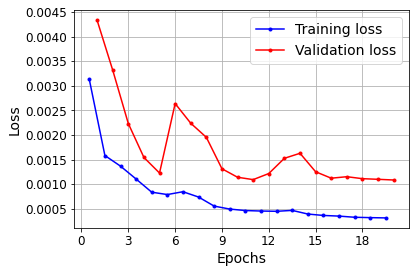

In [10]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

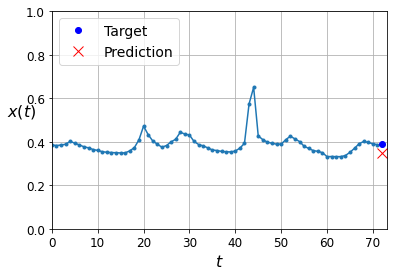

In [11]:
y_pred = model.predict(np.swapaxes(X_valid, 1,2))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead
Iterative method

In [12]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = horizon = 24

# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO2_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")


# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44172, 96)
(44172, 96)
(34272, 72, 1) (34272, 24)
(6581, 72, 1) (6581, 24)
(3319, 72, 1) (3319, 24)


In [13]:
np.random.seed(43) # not 42, as it would give the first series in the train set

X_new = X_test[-1:, :]
Y_new = np.expand_dims(y_test[-1:, :], 2)

display(dataset_df[["NO2_price", "date_time"]].tail(1))

print(f"{X_new.shape=}")
print(f"{Y_new.shape=}")

# X = X_new
X = np.swapaxes(X_new, 1,2)

print(X.shape)

for step_ahead in range(horizon):
    # y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    y_pred_one = model.predict(X[:, :, step_ahead:])

    print(f"{y_pred_one.shape=}")
    #y_pred_one = y_pred_one[:, np.newaxis, :]

    # X = np.concatenate([X, y_pred_one], axis=1)
    print(f"{y_pred_one.shape=}")

    X = np.concatenate([X, y_pred_one], axis=2)
    print(f"{X.shape=}")

print(f"{X.shape=}")
Y_pred = X[:, n_steps:]
Y_pred = X[:,:, n_steps:]

,NO2_price,date_time
44266,0.268144,2021-01-20-22


X_new.shape=(1, 72, 1)
Y_new.shape=(1, 24, 1)
(1, 1, 72)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 73)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 74)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 75)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 76)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 77)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 78)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 79)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 80)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 81)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 82)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 83)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1, 84)
y_pred_one.shape=(1, 1, 1)
y_pred_one.shape=(1, 1, 1)
X.shape=(1, 1

In [14]:
Y_pred = np.swapaxes(Y_pred, 1,2)
print(Y_pred.shape)

(1, 24, 1)


Saving figure forecast_ahead_plot


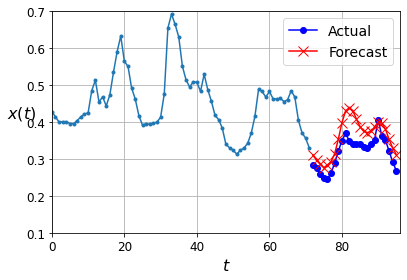

MSE: 0.0020070201760683075


In [15]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig(f"forecast_ahead_plot")
plt.ylim(0.10,0.70)
plt.savefig("../figures/iterative_LSTM.pdf")
plt.show()

mse = keras.metrics.mean_squared_error(Y_new, Y_pred)
print("MSE:",np.mean(mse))

# Linear Regression

In [16]:
# Time series slicing parameters
nbf_features = input_window = n_steps = 72 
nbf_outputs = output_window = 24


# Creating time series traing and evaluation (test) data besed on sliding window approach
time_series, time_series_df = create_time_series_data(dataset_df,                                                                             
                                                      nbf_features, 
                                                      nbf_outputs, 
                                                      column_key="NO2_price", 
                                                      column_suffix="DA",
                                                      include_target_outputs=True)
#time_series_df.to_csv("TIMESERIES_VALIDATION.csv")


# Displaying time series data
time_series_df.index.name = "t"

print(time_series.shape)
print(time_series_df.shape)
# print(time_series_df.columns)

X_train, y_train = time_series[ :34272, :input_window], time_series[ :34272, input_window:]
X_valid, y_valid = time_series[34272:34272+6581, :input_window], time_series[34272:34272+6581, input_window:]
X_test, y_test = time_series[34272+6581:, :input_window], time_series[34272+6581:, input_window:]

# X_train = np.expand_dims(X_train, axis=2)
# X_valid = np.expand_dims(X_valid, axis=2)
# X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(44172, 96)
(44172, 96)
(34272, 72) (34272, 24)
(6581, 72) (6581, 24)
(3319, 72) (3319, 24)


In [17]:
MLR_model = LinearRegression()
MLR_model.fit(X_train, y_train)

LinearRegression()

In [18]:

X_new = X_test[-1:, :]
Y_new = y_test[-1:, :]

display(dataset_df[["NO2_price", "date_time"]].tail(1))

print(f"{X_new.shape=}")
print(f"{Y_new.shape=}")

# X = X_new
X = X_new

Y_pred = MLR_model.predict(X)

print(f"{Y_pred.shape=}")




,NO2_price,date_time
44266,0.268144,2021-01-20-22


X_new.shape=(1, 72)
Y_new.shape=(1, 24)
Y_pred.shape=(1, 24)


In [19]:


mse = keras.metrics.mean_squared_error(Y_new, Y_pred)
print("MSE:",np.mean(mse))

MSE: 0.00772920523885572


# Own NN

In [20]:
from models_project2 import *
eta = 0.05
lmb = 0
hidden_size = 64
act_func = "relu"
act_func = "leaky_relu"
epochs = 200

In [21]:
own_model, tf_model = NN_simple_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         nbf_outputs=1,
                                                         X_test=X_test.copy(), t_test=y_test.copy()[:, :1],
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)

own_model, tf_model = NN_large_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         nbf_outputs=1,
                                                         X_test=X_test.copy(), t_test=y_test.copy()[:, :1],
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(y_train[:, :1])

train_losses, test_losses = own_model.fit(X_train, y_train[:, :1], 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=False, verbose=True)

(34272, 72)
(34272, 24)
[[0.3358241 ]
 [0.32929657]
 [0.27037705]
 ...
 [0.39749206]
 [0.39062097]
 [0.38692777]]
Training epoch 0/200
Epoch=0 | 0.58%
Epoch=0 | 1.17%
Epoch=0 | 1.75%
Epoch=0 | 2.34%
Epoch=0 | 2.92%
Epoch=0 | 3.51%
Epoch=0 | 4.09%
Epoch=0 | 4.68%
Epoch=0 | 5.26%
Epoch=0 | 5.85%
Epoch=0 | 6.43%
Epoch=0 | 7.02%
Epoch=0 | 7.60%
Epoch=0 | 8.19%
Epoch=0 | 8.77%
Epoch=0 | 9.36%
Epoch=0 | 9.94%
Epoch=0 | 10.53%
Epoch=0 | 11.11%
Epoch=0 | 11.70%
Epoch=0 | 12.28%
Epoch=0 | 12.87%
Epoch=0 | 13.45%
Epoch=0 | 14.04%
Epoch=0 | 14.62%
Epoch=0 | 15.20%
Epoch=0 | 15.79%
Epoch=0 | 16.37%
Epoch=0 | 16.96%
Epoch=0 | 17.54%
Epoch=0 | 18.13%
Epoch=0 | 18.71%
Epoch=0 | 19.30%
Epoch=0 | 19.88%
Epoch=0 | 20.47%
Epoch=0 | 21.05%
Epoch=0 | 21.64%
Epoch=0 | 22.22%
Epoch=0 | 22.81%
Epoch=0 | 23.39%
Epoch=0 | 23.98%
Epoch=0 | 24.56%
Epoch=0 | 25.15%
Epoch=0 | 25.73%
Epoch=0 | 26.32%
Epoch=0 | 26.90%
Epoch=0 | 27.49%
Epoch=0 | 28.07%
Epoch=0 | 28.65%
Epoch=0 | 29.24%
Epoch=0 | 29.82%
Epoch=0 | 30.41

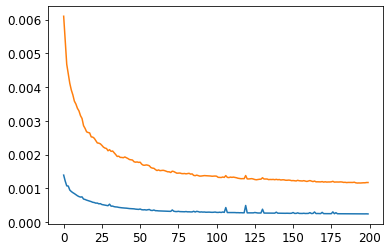

In [23]:
plt.figure()
x_plot = np.arange(train_losses.shape[0])
plt.plot(x_plot, train_losses)
plt.plot(x_plot, test_losses)

In [24]:
#t_hat_test_own = own_model.predict(X)

In [25]:

np.random.seed(43) # not 42, as it would give the first series in the train set

X_new = X_test[-1:, :]
Y_new = y_test[-1:, :]

X = X_new


for step_ahead in range(24):
    # y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    y_pred_one = own_model.predict(X[:, step_ahead:])

    print(y_pred_one)

    print(f"{y_pred_one.shape=}")
    #y_pred_one = y_pred_one[:, np.newaxis, :]

    # X = np.concatenate([X, y_pred_one], axis=1)
    print(f"{y_pred_one.shape=}")

    X = np.concatenate([X, y_pred_one], axis=1)
    print(f"{X.shape=}")

print(f"{X.shape=}")
Y_pred = X[:, n_steps:]


[[0.32965668]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 73)
[[0.33015169]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 74)
[[0.36244858]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 75)
[[0.37317427]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 76)
[[0.37287937]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 77)
[[0.37273312]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 78)
[[0.36529397]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 79)
[[0.40865645]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 80)
[[0.45578333]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 81)
[[0.46675425]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 82)
[[0.47310847]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 83)
[[0.42850676]]
y_pred_one.shape=(1, 1)
y_pred_one.shape=(1, 1)
X.shape=(1, 84)
[[0.41040236]]
y_pred_one.shape=(1, 1)
y_pred_one.sh

In [26]:
X_new = np.expand_dims(X_new,2)
Y_new = np.expand_dims(Y_new,2)
Y_pred = np.expand_dims(Y_pred,2)
print(f"{Y_pred.shape=}")
print(f"{Y_new.shape=}")
print(f"{X_new.shape=}")


Y_pred.shape=(1, 24, 1)
Y_new.shape=(1, 24, 1)
X_new.shape=(1, 72, 1)


Saving figure forecast_ahead_plot


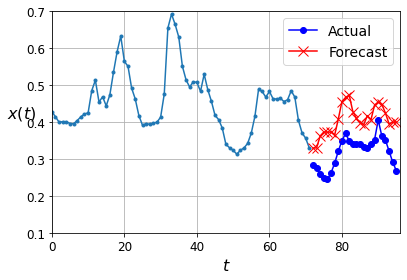

MSE: 0.008299142067129667


In [27]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.ylim(0.10,0.70)
plt.savefig("../figures/iterative_OWN_NN.pdf")
plt.show()


mse = keras.metrics.mean_squared_error(Y_new, Y_pred)
print("MSE:",np.mean(mse))